<a href="https://colab.research.google.com/github/Itsuki-Hamano123/practice-casualeffect/blob/master/jobs_causality/jobs_causalml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip install causalml

     |████████████████████████████████| 3.9MB 2.8MB/s 
     |████████████████████████████████| 276kB 13.7MB/s 
     |████████████████████████████████| 1.8MB 27.4MB/s 
  Created wheel for causalml: filename=causalml-0.8.0-cp36-cp36m-linux_x86_64.whl size=482074 sha256=812420e4d268abdc531c97095bfaf46e4016ea895da53f574af88538341f4adc
  Stored in directory: /root/.cache/pip/wheels/db/d8/1f/c5c57e0a0a1e2d597da3b4b73f26a0365874e363bb1b57db41
  Created wheel for shap: filename=shap-0.35.0-cp36-cp36m-linux_x86_64.whl size=394110 sha256=e5dce276cd7a517b8665ec6a082847ed22e410efefbfc59c59180baaf043b72f
  Stored in directory: /root/.cache/pip/wheels/e7/f7/0f/b57055080cf8894906b3bd3616d2fc2bfd0b12d5161bcb24ac
Successfully built causalml shap


In [2]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive
%cd /gdrive/My Drive/機械学習練習/統計的因果推論/因果推論実践用/jobs_causality
%ls

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive
/gdrive
/gdrive/My Drive/機械学習練習/統計的因果推論/因果推論実践用/jobs_causality
dataset/             jobs_dowhy.ipynb
jobs_causalml.ipynb  jobs_rct_causalml_xlearner.ipynb


# 職業訓練データセットでCausalmlの練習

In [3]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from causalml.inference.meta import BaseXRegressor, XGBTRegressor, LRSRegressor
from causalml.metrics import get_tmlegain, plot_tmlegain, plot_tmleqini, Sensitivity
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor, XGBClassifier

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.


## 職業訓練データセット読み込み
**職業訓練を受けた人は、収入がどのくらい増加/減少するのか因果分析**<br>
Lalondeが分析した職業訓練データセットの詳細について：[http://users.nber.org/~rdehejia/nswdata.html](http://users.nber.org/~rdehejia/nswdata.html)

Dataset description
* treat: 1 if the subject participated in the job  training program, 0 otherwise
* age: the subject's age
* educ: years of education
* race: categorical variable with three possible values: Black, Hispanic, or White
* married: 1 if the subject was married at the time of the training program, 0 otherwise
* nodegree: 1 if the subject has earned no school degree, 0 otherwise
* re74: real earnings in 1974 (pre-treatment)
* re75: real earnings in 1975 (pre-treatment)
* re78: real earnings in 1978 (outcome)

In [4]:
csv_path = 'dataset/job_lalonde.csv'
df= pd.read_csv(csv_path)

OUTCOME_COLUMN = 're78'
TREATMENT_COLUMN = 'treat'
UNNECESSARY_COLUMNS = ['ps', 'ips_weight', 'tips_weight',
       'cips_weight', 'ips_normalized_weight', 'tips_normalized_weight',
       'cips_normalized_weight', 'ips_stabilized_weight',
       'tips_stabilized_weight', 'cips_stabilized_weight', 'd_y', 'dbar_y']
FEATURE_COLUMNS = list(df.drop(columns=[OUTCOME_COLUMN, TREATMENT_COLUMN]+UNNECESSARY_COLUMNS).columns)

df[TREATMENT_COLUMN] = df[TREATMENT_COLUMN] * 1

print('outcome:{col}'.format(col=OUTCOME_COLUMN))
print('treatment:{col}'.format(col=TREATMENT_COLUMN))
print('features:{cols}'.format(cols=FEATURE_COLUMNS))

df.drop(columns=UNNECESSARY_COLUMNS).head()

outcome:re78
treatment:treat
features:['age', 'educ', 'black', 'hisp', 'married', 'nodegr', 're74', 're75', 'u74', 'u75']


,age,educ,black,hisp,married,nodegr,re74,re75,re78,u74,u75,treat
0,37,11,1,0,1,1,0.0,0.0,9930.05,1,1,1
1,22,9,0,1,0,1,0.0,0.0,3595.89,1,1,1
2,30,12,1,0,0,0,0.0,0.0,24909.50,1,1,1
3,27,11,1,0,0,1,0.0,0.0,7506.15,1,1,1
4,33,8,1,0,0,1,0.0,0.0,289.79,1,1,1


In [5]:
df.describe()

,age,educ,black,hisp,married,nodegr,re74,re75,re78,u74,u75,treat,ps,ips_weight,tips_weight,cips_weight,ips_normalized_weight,tips_normalized_weight,cips_normalized_weight,ips_stabilized_weight,tips_stabilized_weight,cips_stabilized_weight,d_y,dbar_y
count,445.000000,445.000000,445.000000,445.00000,445.000000,445.000000,445.000000,445.000000,445.000000,445.000000,445.000000,445.000000,445.000000,445.000000,445.000000,445.000000,445.000000,445.000000,445.000000,445.000000,445.000000,445.000000,445.000000,445.000000
mean,25.370787,10.195506,0.833708,0.08764,0.168539,0.782022,2102.265533,1377.138638,5300.765138,0.732584,0.649438,0.415730,0.419655,0.004490,0.004537,0.004457,0.004494,0.004494,0.004494,0.002248,0.002272,0.002231,14.099805,10.430304
std,7.100282,1.792119,0.372762,0.28309,0.374766,0.413337,5363.583863,3150.961433,6631.493362,0.443109,0.477683,0.493402,0.061065,0.000928,0.001078,0.001087,0.000962,0.001092,0.001127,0.000275,0.000462,0.000337,32.577060,19.194586
min,17.000000,3.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.175710,0.002726,0.001152,0.002835,0.002705,0.001131,0.002884,0.001593,0.000673,0.001179,0.000000,0.000000
25%,20.000000,9.000000,1.000000,0.00000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.373260,0.003644,0.003359,0.003846,0.003615,0.003297,0.003846,0.002066,0.001963,0.002247,0.000000,0.000000
50%,24.000000,10.000000,1.000000,0.00000,0.000000,1.000000,0.000000,0.000000,3701.810000,1.000000,1.000000,0.000000,0.399351,0.004289,0.005252,0.003846,0.004267,0.005155,0.003846,0.002195,0.002247,0.002247,0.000000,0.000000
75%,28.000000,11.000000,1.000000,0.00000,0.000000,1.000000,824.389000,1220.840000,8124.720000,1.000000,1.000000,1.000000,0.469206,0.005206,0.005405,0.004994,0.005233,0.005405,0.005080,0.002461,0.002247,0.002247,12.563586,15.667131
max,55.000000,16.000000,1.000000,1.00000,1.000000,1.000000,39570.700000,25142.200000,60307.900000,1.000000,1.000000,1.000000,0.578452,0.007998,0.007417,0.009843,0.008078,0.007280,0.010012,0.003325,0.004334,0.004092,293.116011,169.035818


### 単純な平均値の比較について

今回求めた推定量を$\hat{\tau}_{naive}$と置くと
$$\hat{\tau}_{naive} = E[Y^{(1)}|t=1]-E[Y^{(0)}|t=0]$$
$$=E[Y^{(1)}-Y^{(0)}]+E[Y^{(0)}|t=1]-E[Y^{(0)}|t=0]$$
セレクションバイアスが生じているため、**単純な平均値の差の比較**では望ましくない因果効果の算出方法であることが分かる。(今回のデータセットについては実験方法がRCTなので介入の割り当てが無作為なためセレクションバイアスは生じづらいと考えられる)<br>

In [6]:
control_group = df.query(TREATMENT_COLUMN + '==False')[OUTCOME_COLUMN].mean()
treatment_group = df.query(TREATMENT_COLUMN + '==True')[OUTCOME_COLUMN].mean()
print('介入群のアウトカムの平均値:{}'.format(control_group))
print('コントロール群のアウトカムの平均値:{}'.format(treatment_group))
print('単純な平均値の差:{}'.format(treatment_group-control_group))

介入群のアウトカムの平均値:4554.802282692311
コントロール群のアウトカムの平均値:6349.1453675675675
単純な平均値の差:1794.3430848752569


## IPW法で因果効果を算出

In [7]:
ps = df['ps']
y = df['re78']
z = df['treat']

ey1 = z*y/ps / sum(z/ps)
ey0 = (1-z)*y/(1-ps) / sum((1-z)/(1-ps))
ate = ey1.sum()-ey0.sum()
print("Causal Estimate is " + str(ate))

Causal Estimate is 1731.2892609440623


## Learnerアルゴリズムの使用

In [8]:
SEED = 2

data = df.drop(columns=UNNECESSARY_COLUMNS)

train_X, test_X, train_t, test_t, train_y, test_y = train_test_split(data.drop(columns=[TREATMENT_COLUMN, OUTCOME_COLUMN]).values,
                                                                     data[TREATMENT_COLUMN].values,
                                                                     data[OUTCOME_COLUMN].values,
                                                                     test_size=0.2, random_state=SEED)
train_X, val_X, train_t, val_t, train_y, val_y = train_test_split(train_X, train_t, train_y,
                                                                  test_size=0.2, random_state=SEED)

print('data.shape:{}'.format(data.shape))
print('train_X:{}, train_t:{}, train_y:{}'.format(train_X.shape, train_t.shape, train_y.shape))
print('val_X:{}, val_t:{}, val_y:{}'.format(val_X.shape, val_t.shape, val_y.shape))
print(('test_X:{}, test_t:{}, test_y:{}'.format(test_X.shape, test_t.shape, test_y.shape)))

data.shape:(445, 12)
train_X:(284, 10), train_t:(284,), train_y:(284,)
val_X:(72, 10), val_t:(72,), val_y:(72,)
test_X:(89, 10), test_t:(89,), test_y:(89,)


### 傾向スコアモデル作成

In [9]:
# causalmlで使用できるElasticNetPropensityModelでは内部でsklearn.linear_model.ElasticNetCVが使われている
# ElasticNetPropensityModelでは検証用データを使えなさそうなので、過学習を防ぐためにも今回はxgboostを使用
# ps：propensity score(傾向スコア)
ps_model = XGBClassifier(n_estimators=1000, random_state=SEED)
# 目的変数をTreatmentとして学習
ps_model.fit(X=train_X, y=train_t, eval_set=[(val_X, val_t)],
             early_stopping_rounds=10)

# 傾向スコア算出
train_ps = ps_model.predict_proba(data=train_X)[:,1]
val_ps = ps_model.predict_proba(data=val_X)[:,1]
print('train_ps:{}, val_ps:{}'.format(train_ps.shape, val_ps.shape))
print('train_ps[:5]:{}'.format(train_ps[:5]))

[0]	validation_0-error:0.5
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.5
[2]	validation_0-error:0.5
[3]	validation_0-error:0.5
[4]	validation_0-error:0.5
[5]	validation_0-error:0.5
[6]	validation_0-error:0.527778
[7]	validation_0-error:0.527778
[8]	validation_0-error:0.527778
[9]	validation_0-error:0.527778
[10]	validation_0-error:0.541667
Stopping. Best iteration:
[0]	validation_0-error:0.5

train_ps:(284,), val_ps:(72,)
train_ps[:5]:[0.4767683 0.5148605 0.5148605 0.4767683 0.4767683]


In [10]:
test_ps_score = ps_model.score(X=test_X, y=test_t)
print('テストデータに対する傾向スコアモデルの精度:{score}'.format(score=test_ps_score))

テストデータに対する傾向スコアモデルの精度:0.4943820224719101


RCTで行われていることで、傾向スコアモデルが介入群とコントロール群を見分けられないほど、共変量に差が無いのかもしれないと考えられる

### MetaLearnerモデル作成

In [11]:
# 観測されたアウトカムから反事実を予測するMetaLearnerモデルを構築していく
# 一般的なMLの学習タスクと異なり、正解に反事実が含まれるためmae,val_loss等を算出できない
# 今回は、傾向スコアモデル学習時と異なり、学習データを少しでも水増しさせるため検証データを加える
learner_train_X = np.concatenate([train_X, val_X])
learner_train_t = np.concatenate([train_t, val_t])
learner_train_y = np.concatenate([train_y, val_y])
learner_train_ps = np.concatenate([train_ps, val_ps])
print('learner_train_ps:{}'.format(learner_train_ps.shape))

learner_train_ps:(356,)


In [12]:
%%time
x_learner = BaseXRegressor(XGBRegressor(n_estimators=1000,random_state=SEED))

x_learner.fit(X=learner_train_X, treatment=learner_train_t, 
              y=learner_train_y, p=learner_train_ps)

[04:39:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:39:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:39:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:39:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
CPU times: user 532 ms, sys: 26.9 ms, total: 559 ms
Wall time: 565 ms


In [13]:
%%time
t_learner = XGBTRegressor(ate_alpha=0.05, n_estimators=1000, random_state=SEED)
t_learner.fit(X=learner_train_X, treatment=learner_train_t, y=learner_train_y)

[04:39:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:39:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
CPU times: user 257 ms, sys: 6.86 ms, total: 264 ms
Wall time: 267 ms


## 予測結果の確認
公式チュートリアルで構築されたモデルの予測結果[https://github.com/uber/causalml/blob/master/examples/dragonnet_example.ipynb](https://github.com/uber/causalml/blob/master/examples/dragonnet_example.ipynb)

In [14]:
# 解析対象となるデータ用意(学習/検証/テストデータの結合)
learner_input_X = np.concatenate([train_X, val_X, test_X])
learner_input_t = np.concatenate([train_t, val_t, test_t])
learner_input_y = np.concatenate([train_y, val_y, test_y])

test_ps = ps_model.predict_proba(test_X)[:,1]
learner_input_ps = np.concatenate([train_ps, val_ps, test_ps])
print('learner_input_ps:{}'.format(learner_input_ps.shape))

learner_input_ps:(445,)


### ATE:AverageTreatmentEffect（平均因果効果）

In [15]:
%%time
x_ate = x_learner.estimate_ate(X=learner_input_X, treatment=learner_input_t,
                             y=learner_input_y, p=learner_input_ps)
t_ate = t_learner.estimate_ate(X=learner_input_X, treatment=learner_input_t,
                               y=learner_input_y)

[04:39:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:39:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:39:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:39:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:39:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:39:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
CPU times: user 1.03 s, sys: 30.1 ms, total: 1.06 s
Wall time: 1.07 s


In [16]:
# ATE:AverageTreatmentEffectp
print('x-learnerのATE:{ate}'.format(ate=x_ate[0][0]))
print('信頼区間の下限値(LB):{lb}'.format(lb=x_ate[1][0]))
print('信頼区間の上限値(UB):{ub}'.format(ub=x_ate[2][0]))
print('t-learnerのATE:{ate}'.format(ate=t_ate[0][0]))
print('信頼区間の下限値(LB):{lb}'.format(lb=t_ate[1][0]))
print('信頼区間の上限値(UB):{ub}'.format(ub=t_ate[2][0]))

x-learnerのATE:1924.7883469485164
信頼区間の下限値(LB):1115.5002739259014
信頼区間の上限値(UB):2734.076419971131
t-learnerのATE:1933.7731893475136
信頼区間の下限値(LB):1033.5334511635929
信頼区間の上限値(UB):2834.0129275314343


### ITE:IndividualTreatmentEffect（個別的因果効果）

In [17]:
%%time
x_ite = x_learner.predict(X=learner_input_X, treatment=learner_input_t,
                        y=learner_input_y, p=learner_input_ps)
t_ite = t_learner.predict(X=learner_input_X, treatment=learner_input_t, y=learner_input_y)

CPU times: user 71.1 ms, sys: 0 ns, total: 71.1 ms
Wall time: 76.4 ms


In [18]:
# ITE:IndividualTreatmentEffect
insert_columns = ['X_ITE', 'T_ITE']
insert_val = [x_ite, t_ite]
for insert_col, val in zip(insert_columns, insert_val):
  if insert_col in data.columns:
    data.drop(columns=insert_col,inplace=True)
  data.insert(loc=0, column=insert_col, value=val)
data

,T_ITE,X_ITE,age,educ,black,hisp,married,nodegr,re74,re75,re78,u74,u75,treat
0,3257.140137,6900.692383,37,11,1,0,1,1,0.00,0.0,9930.05,1,1,1
1,8398.496094,7879.037109,22,9,0,1,0,1,0.00,0.0,3595.89,1,1,1
2,143.145752,35.841721,30,12,1,0,0,0,0.00,0.0,24909.50,1,1,1
3,-1892.088867,-1349.422241,27,11,1,0,0,1,0.00,0.0,7506.15,1,1,1
4,-2784.637695,3199.215820,33,8,1,0,0,1,0.00,0.0,289.79,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
440,3754.640381,1914.254639,21,9,1,0,0,1,31886.40,12357.2,0.00,0,0,0
441,6363.058594,3479.741699,28,11,1,0,0,1,17491.50,13371.3,0.00,0,0,0
442,-5946.514648,-5542.077148,29,9,0,1,0,1,9594.31,16341.2,16900.30,0,0,0
443,-1945.338135,-3606.191895,25,9,1,0,1,1,24731.60,16946.6,7343.96,0,0,0


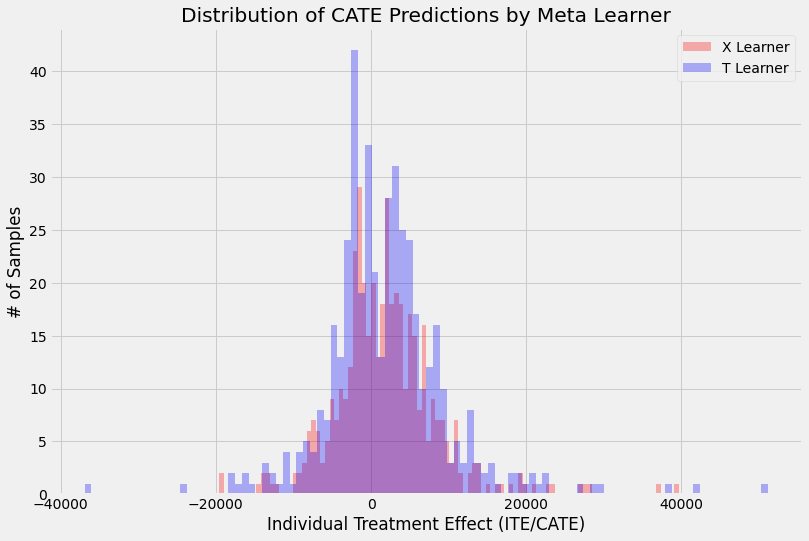

In [50]:
alpha=0.3
bins=100
plt.figure(figsize=(12,8))
plt.hist(x_ite, alpha=alpha, bins=bins, label='X Learner', color='red')
plt.hist(t_ite, alpha=alpha, bins=bins, label='T Learner', color='blue')
plt.title('Distribution of CATE Predictions by Meta Learner')
plt.xlabel('Individual Treatment Effect (ITE/CATE)')
plt.ylabel('# of Samples')
_=plt.legend()

### 特徴量毎の重要度の確認

[04:39:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:39:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


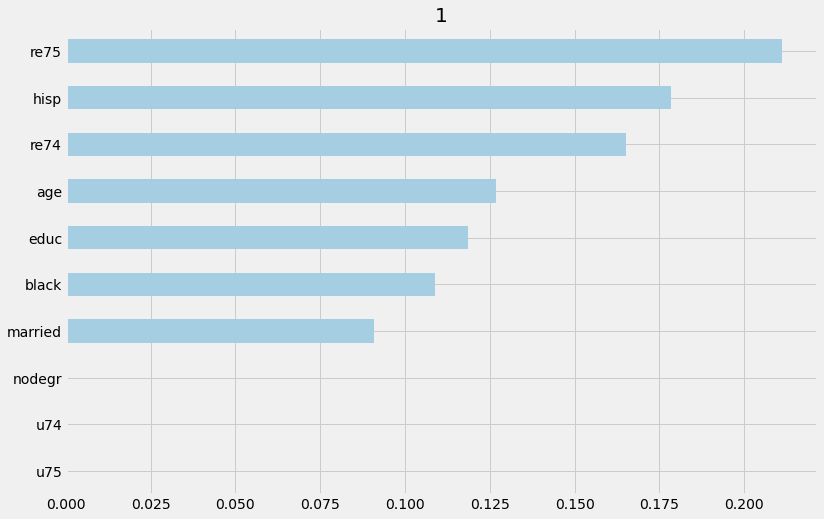

In [20]:
x_learner.plot_importance(X=learner_input_X,
                          tau=x_ite,
                          model_tau_feature=XGBRegressor(random_state=SEED),
                          features=FEATURE_COLUMNS,
                          method='auto',
                          random_state=SEED)

### 特徴量毎のshap値確認

[04:39:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:39:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


Setting feature_perturbation = "tree_path_dependent" because no background data was given.


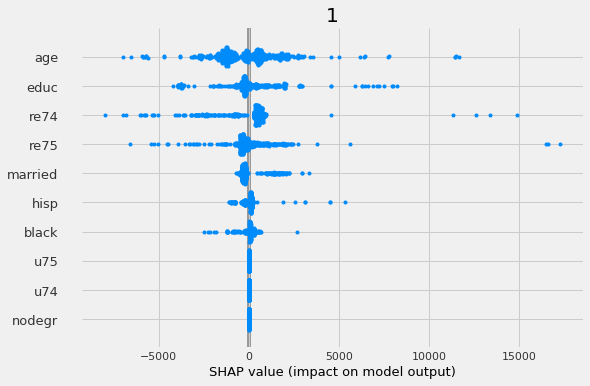

In [21]:
x_learner.plot_shap_values(X=learner_input_X, tau=x_ite, 
                           features=FEATURE_COLUMNS,
                           model_tau_feature=XGBRegressor(random_state=SEED))

## モデルの評価
TMLE:Targeted maximum likelihood estimation(局所的に最尤推定を行う)モデルとの比較。<br>正解となる目的変数にはCounterfactual(反事実)が含まれているため、一般的な精度が算出できない。そこでTMLEモデルをベースラインにして、構築したモデルの精度を比較し評価する。

In [22]:
# 傾向スコアの挿入
PS_COLUMN = 'ps'
insert_column = PS_COLUMN

if insert_column in data.columns:
  data.drop(columns=insert_column,inplace=True)
data.insert(loc=0, column=insert_column, value=learner_input_ps)
data.head()

,ps,T_ITE,X_ITE,age,educ,black,hisp,married,nodegr,re74,re75,re78,u74,u75,treat
0,0.476768,3257.140137,6900.692383,37,11,1,0,1,1,0.0,0.0,9930.05,1,1,1
1,0.514861,8398.496094,7879.037109,22,9,0,1,0,1,0.0,0.0,3595.89,1,1,1
2,0.514861,143.145752,35.841721,30,12,1,0,0,0,0.0,0.0,24909.50,1,1,1
3,0.476768,-1892.088867,-1349.422241,27,11,1,0,0,1,0.0,0.0,7506.15,1,1,1
4,0.476768,-2784.637695,3199.215820,33,8,1,0,0,1,0.0,0.0,289.79,1,1,1


In [24]:
tmlgeain = get_tmlegain(df=data,inference_col=FEATURE_COLUMNS, 
                        learner=XGBRegressor(n_estimators=1000, random_state=SEED),
                        outcome_col=OUTCOME_COLUMN, treatment_col=TREATMENT_COLUMN,
                        p_col=PS_COLUMN,ci=True)
tmlgeain

[04:39:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:39:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:39:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


,T_ITE,X_ITE,T_ITE LB,X_ITE LB,T_ITE UB,X_ITE UB,Random
0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
0.2,145.574117,181.985489,-159.649584,-114.332927,450.797818,478.303906,247.373053
0.4,440.666505,652.783310,-158.505299,1.122498,1039.838310,1304.444122,494.746106
0.6,732.386346,640.496073,-203.488526,-254.323932,1668.261217,1535.316079,742.119159
0.8,1000.128689,1057.125227,-223.276742,-103.443170,2223.534120,2217.693625,989.492212
1.0,1236.865265,1236.865265,568.791316,568.791316,1904.939215,1904.939215,1236.865265


[04:39:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:39:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:39:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


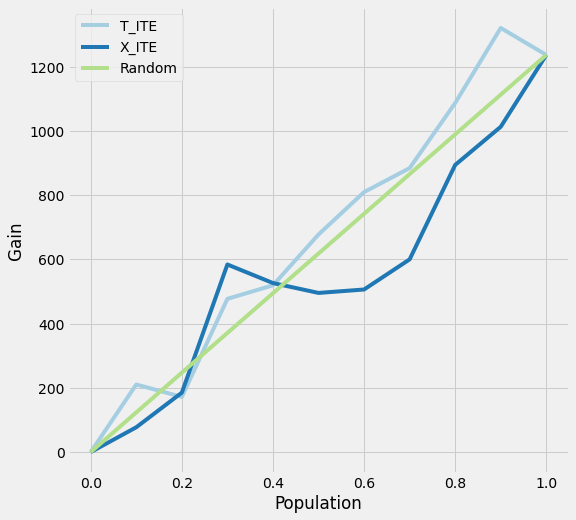

In [25]:
plot_tmlegain(df=data,inference_col=FEATURE_COLUMNS, 
              learner=XGBRegressor(n_estimators=1000, random_state=SEED),
              outcome_col=OUTCOME_COLUMN, treatment_col=TREATMENT_COLUMN, p_col=PS_COLUMN,
              n_segment=10)

[04:39:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:39:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:39:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


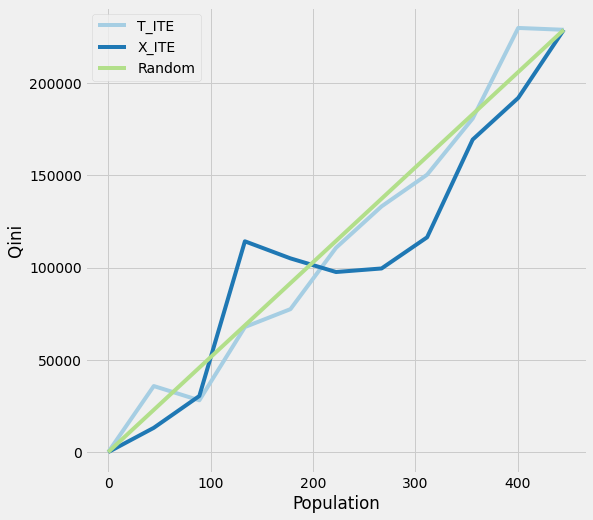

In [26]:
plot_tmleqini(df=data,inference_col=FEATURE_COLUMNS, 
              learner=XGBRegressor(n_estimators=1000, random_state=SEED),
              outcome_col=OUTCOME_COLUMN, treatment_col=TREATMENT_COLUMN, p_col=PS_COLUMN,
              n_segment=10)

## T-Learnerについて感度分析
元のデータを一部変化させることで、推定された因果効果のロバスト性を確認する分析手法<br>
causalmlドキュメントに挙げられている感度分析の種類
* Placebo Treatment
* Irrelevant Additional Confounder
* Subset validation
* Random Replace
* Selection Bias


In [27]:
data.head()

,ps,T_ITE,X_ITE,age,educ,black,hisp,married,nodegr,re74,re75,re78,u74,u75,treat
0,0.476768,3257.140137,6900.692383,37,11,1,0,1,1,0.0,0.0,9930.05,1,1,1
1,0.514861,8398.496094,7879.037109,22,9,0,1,0,1,0.0,0.0,3595.89,1,1,1
2,0.514861,143.145752,35.841721,30,12,1,0,0,0,0.0,0.0,24909.50,1,1,1
3,0.476768,-1892.088867,-1349.422241,27,11,1,0,0,1,0.0,0.0,7506.15,1,1,1
4,0.476768,-2784.637695,3199.215820,33,8,1,0,0,1,0.0,0.0,289.79,1,1,1


In [28]:
# Sensitivityクラスのインスタンス化
sensitivity = Sensitivity(df=data.drop(columns=['X_ITE']),
                          inference_features=FEATURE_COLUMNS,
                          p_col=PS_COLUMN, treatment_col=TREATMENT_COLUMN,
                          outcome_col=OUTCOME_COLUMN, learner=t_learner)
# ATEの再確認
s_ate_ci = sensitivity.get_ate_ci(X=learner_input_X, p=learner_input_ps,
                                  treatment=learner_input_t, y=learner_input_y)
print('ATE:{ate}'.format(ate=s_ate_ci[0]))
print('信頼区間の下限値(LB):{lb}'.format(lb=s_ate_ci[1]))
print('信頼区間の上限値(UB):{ub}'.format(ub=s_ate_ci[2]))

[04:39:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:39:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
ATE:1933.7731893475136
信頼区間の下限値(LB):1033.5334511635929
信頼区間の上限値(UB):2834.0129275314343


In [29]:
# causalmlで使用可能な感度分析一覧
sensitivity_methods = ['Placebo Treatment', 'Random Cause',
                      'Subset Data', 'Random Replace', 
                      'Selection Bias']
sensitivity_methods

['Placebo Treatment',
 'Random Cause',
 'Subset Data',
 'Random Replace',
 'Selection Bias']

confound引数に渡せる関数一覧
* one_sided
* alignment
* one_sided_att
* alignment_att<br>
[詳細：https://www.mattblackwell.org/files/papers/causalsens.pdf](https://www.mattblackwell.org/files/papers/causalsens.pdf)

### sample_size=0.2

In [38]:
%%time
sensitivity_result = sensitivity.sensitivity_analysis(methods=sensitivity_methods,
                                             sample_size=0.2, confound='alignment_att')

[04:43:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:43:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:43:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:43:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:43:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:43:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:43:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:43:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

In [40]:
pd.options.display.max_colwidth = 100
sensitivity_result.reset_index(drop=True)

,Method,ATE,New ATE,New ATE LB,New ATE UB
0,Placebo Treatment,1933.77,-536.768,-1368.48,294.942
1,Random Cause,1933.77,1311.88,566.47,2057.28
2,Subset Data(sample size @0.2),1933.77,5230.25,3190.43,7270.07
3,Random Replace,1933.77,1547.83,810.753,2284.91
4,"Selection Bias (alpha@-4062.36, with r-sqaure:0.04209",1933.77,-2130.43,-3031.72,-1229.13
5,"Selection Bias (alpha@-3249.888, with r-sqaure:0.02728",1933.77,-1338.7,-2239.59,-437.802
6,"Selection Bias (alpha@-2437.416, with r-sqaure:0.01549",1933.77,-503.643,-1404.96,397.676
7,"Selection Bias (alpha@-1624.944, with r-sqaure:0.00685",1933.77,261.44,-640.262,1163.14
8,"Selection Bias (alpha@-812.472, with r-sqaure:0.00171",1933.77,1102.63,199.513,2005.74
9,"Selection Bias (alpha@-0.0, with r-sqaure:0.0",1933.77,1933.77,1033.53,2834.01
